# Gluino pair production with decays to 1st generation fermions
This notebook examines the differences between fully supervised and weakly supervised artifical neural networks in separating gluino pair production from the dominant SM background. As we find the weakly supervised networks work better than expected, and are failry robust, we also test a how the networks behave when they are given unexpected events. This will include a test on mis-modelled data and gluino pair production when the decays are predominantely to 1st generation fermions. Lastly, we will show that the combination of weak supervision with full supervision can yield even better results.

## First load the required packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as colors

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.callbacks

plt.rcParams.update({'font.family':'cmr10','font.size': 12})
# plt.rc('text', usetex = False)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## Load the initial datasets

In [3]:
ZJet = pd.read_csv('./Z_Jets_data.txt',dtype=float)
x_cols = list(ZJet.columns)
x_cols.remove('weight')
ZJet['Y']=0
ZJet['XS']=28.83
print ZJet.head()
print len(ZJet)

          MET      PT(J1)     PT(J2)     PT(J3)  PT(J4)  PT(J5)  PT(J6)  \
0  253.087784  250.320816   0.000000   0.000000     0.0     0.0     0.0   
1  261.409821  229.624542  45.158997   0.000000     0.0     0.0     0.0   
2  232.673737  277.371552  68.850410   0.000000     0.0     0.0     0.0   
3  217.952271  221.364166   0.000000   0.000000     0.0     0.0     0.0   
4  271.402985  247.162766  97.523376  45.099197     0.0     0.0     0.0   

   PT(J7)  PT(J8)  PT(J9)  PT(J10)    weight  Y     XS  
0     0.0     0.0     0.0      0.0  0.000057  0  28.83  
1     0.0     0.0     0.0      0.0  0.000057  0  28.83  
2     0.0     0.0     0.0      0.0  0.000057  0  28.83  
3     0.0     0.0     0.0      0.0  0.000057  0  28.83  
4     0.0     0.0     0.0      0.0  0.000057  0  28.83  
264303


In [4]:
Gluinos_1stGen = pd.read_csv('Gluino_r2.txt',dtype=float)
Gluinos_1stGen.head()

,MET,PT(J1),PT(J2),PT(J3),PT(J4),PT(J5),PT(J6),PT(J7),PT(J8),PT(J9),PT(J10),weight
0,1035.262695,1025.169189,957.710632,605.566101,195.419067,106.979652,58.156300,0.000000,0.000000,0.0,0.0,6.370780e-10
1,741.380493,1317.837036,677.725220,223.478897,208.367645,121.742661,54.644085,0.000000,0.000000,0.0,0.0,6.370780e-10
2,1091.600464,925.912964,726.345032,716.401917,182.365189,0.000000,0.000000,0.000000,0.000000,0.0,0.0,6.370780e-10
3,919.562744,541.299500,498.659943,455.610474,418.091644,206.259903,167.933517,66.530518,42.658268,0.0,0.0,6.370780e-10
4,761.842529,1153.671021,1060.496582,818.396973,110.987244,54.105381,0.000000,0.000000,0.000000,0.0,0.0,6.370780e-10


Build a test set, which is made up of 10% of each of the samples. This will always be what we test against. The rest of the data will be used for a fully supervised network and a weakly supervised.

In [5]:
test_gluinos_1st = int(len(Gluinos_1stGen)*0.1)
test_z = int(len(ZJet)*0.1)

test_x_raw_1st = Gluinos_1stGen[:test_gluinos_1st][x_cols]
test_y_1st = np.ones(test_gluinos_1st)
test_x_raw_1st = np.vstack([test_x_raw_1st, ZJet[:test_z][x_cols]])
test_y_1st = np.append(test_y_1st,np.zeros(test_z))

print "X shape:", test_x_raw_1st.shape
print "Y shape:", test_y_1st.shape

X shape: (73765, 11)
Y shape: (73765,)


In [6]:
train_x_raw_1st = Gluinos_1stGen[test_gluinos_1st:][x_cols]
train_y_1st = np.ones(len(Gluinos_1stGen)-test_gluinos_1st)

train_x_raw_1st = np.vstack([train_x_raw_1st, ZJet[test_z:][x_cols]])
train_y_1st = np.append(train_y_1st,np.zeros(len(ZJet)-test_z))

print "X shape:", train_x_raw_1st.shape
print "Y shape:", train_y_1st.shape

X shape: (663897, 11)
Y shape: (663897,)


Now split the 'training' data up into a real training and validation set.

In [7]:
x_train_1st_raw, x_valid_1st_raw, Y_TRAIN_1st, Y_VALID_1st =  train_test_split(train_x_raw_1st,
                                                                       train_y_1st,
                                                                       test_size=0.2,
                                                                       random_state=42)

Scale the data so that it has a mean of 0 and unit standard deviation.

In [8]:
scaler1st = StandardScaler()

x_train_1st = scaler1st.fit_transform(x_train_1st_raw)
x_valid_1st = scaler1st.transform(x_valid_1st_raw)
x_test_1st = scaler1st.transform(test_x_raw_1st)

## Initial network training
### Fully supervised network

In [9]:
FullySupervisedModel= Sequential()
FullySupervisedModel.add(Dense(30, activation="sigmoid", kernel_initializer="normal", input_dim=11))
FullySupervisedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
FullySupervisedModel.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01))

In [10]:
# On the first run, uncomment the next two lines. This will train the model and save the results
# FullySupervisedModel.fit(x_train_1st,Y_TRAIN_1st,validation_data=(x_valid_1st,Y_VALID_1st))
# FullySupervisedModel.save('FullySupervisedGluinos_1stgen.h5')
FullySupervisedModel.load_weights('FullySupervisedGluinos_1stgen.h5')

### Weakly supervised network
First define the cost function

In [11]:
# for custom metrics
import keras.backend as K
def WeakSupervision(y_true, y_pred):
    return K.abs((K.mean(y_pred, axis=-1) - K.mean(y_true,axis=-1)))

#### Data preparation
Set the labels (ratios) for two different datasets. Use a 80% of the background and 40% of the signal for one set and the remaining 20% and 60% for the second dataset

In [12]:
length_0_1st = x_train_1st[Y_TRAIN_1st==0].shape[0]
length_1_1st = x_train_1st[Y_TRAIN_1st==1].shape[0]
print length_0_1st, length_1_1st

190314 340803


In [13]:
# Set A: 80% of total background and 40% of total signal
set_a_0_1st = x_train_1st[Y_TRAIN_1st==0][:int(0.8*length_0_1st)]
set_a_1_1st = x_train_1st[Y_TRAIN_1st==1][:int(0.4*length_1_1st)]
percentage_a_1st = (0.4*length_1_1st)/(0.4*length_1_1st+0.8*length_0_1st)
print "Percentage of signal for set A:", percentage_a_1st
set_a_1st = np.vstack([set_a_0_1st,set_a_1_1st])
set_a_percentages_1st = np.ones(set_a_1st.shape[0])*percentage_a_1st
set_a_truth_1st = np.append(np.zeros(int(0.8*length_0_1st)),np.ones(int(0.4*length_1_1st)))
print len(set_a_truth_1st),len(set_a_1st),len(set_a_percentages_1st)

Percentage of signal for set A: 0.472398607767
288572 288572 288572


In [14]:
# Set B: last 20% of total background and last 60% of total signal
set_b_0_1st = x_train_1st[Y_TRAIN_1st==0][int(0.8*length_0_1st):]
set_b_1_1st = x_train_1st[Y_TRAIN_1st==1][int(0.4*length_1_1st):]
percentage_b_1st = (0.6*length_1_1st)/(0.6*length_1_1st+0.2*length_0_1st)
print "Percentage of signal for set B:", percentage_b_1st
set_b_1st = np.vstack([set_b_0_1st,set_b_1_1st])
set_b_percentages_1st = np.ones(set_b_1st.shape[0])*percentage_b_1st
set_b_truth_1st = np.append(np.zeros(length_0_1st-int(0.8*length_0_1st)),np.ones(length_1_1st-int(0.4*length_1_1st)))
print len(set_b_truth_1st),len(set_b_1st),len(set_b_percentages_1st)

Percentage of signal for set B: 0.843068862387
242545 242545 242545


In [15]:
# Now split up the validation data in the same way

length_0_1stv = x_valid_1st[Y_VALID_1st==0].shape[0]
length_1_1stv = x_valid_1st[Y_VALID_1st==1].shape[0]

# Set A: 80% of total validation background and 40% of total signal
set_a_0_1stv = x_valid_1st[Y_VALID_1st==0][:int(0.8*length_0_1stv)]
set_a_1_1stv = x_valid_1st[Y_VALID_1st==1][:int(0.4*length_1_1stv)]
percentage_a_1stv = (0.4*length_1_1stv)/(0.4*length_1_1stv+0.8*length_0_1stv)
print "Percentage of signal for set A validation:", percentage_a_1stv
set_a_1stv = np.vstack([set_a_0_1stv,set_a_1_1stv])
set_a_percentages_1stv = np.ones(set_a_1stv.shape[0])*percentage_a_1stv
set_a_truth_1stv = np.append(np.zeros(int(0.8*length_0_1stv)),np.ones(int(0.4*length_1_1stv)))
print len(set_a_truth_1stv),len(set_a_1stv),len(set_a_percentages_1stv)

# Set B: last 20% of total background and last 60% of total signal
set_b_0_1stv = x_valid_1st[Y_VALID_1st==0][int(0.8*length_0_1stv):]
set_b_1_1stv = x_valid_1st[Y_VALID_1st==1][int(0.4*length_1_1stv):]
percentage_b_1stv = (0.6*length_1_1stv)/(0.6*length_1_1stv+0.2*length_0_1stv)
print "Percentage of signal for set B:", percentage_b_1stv
set_b_1stv = np.vstack([set_b_0_1stv,set_b_1_1stv])
set_b_percentages_1stv = np.ones(set_b_1stv.shape[0])*percentage_b_1stv
set_b_truth_1stv = np.append(np.zeros(length_0_1stv-int(0.8*length_0_1stv)),np.ones(length_1_1stv-int(0.4*length_1_1stv)))
print len(set_b_truth_1stv),len(set_b_1stv),len(set_b_percentages_1stv)

Percentage of signal for set A validation: 0.472560011977
72135 72135 72135
Percentage of signal for set B: 0.84315452045
60645 60645 60645


In [16]:
# combine sets A and B to make one training and validation set
X_Train_1st = np.vstack([set_a_1st,set_b_1st])
X_Valid_1st = np.vstack([set_a_1stv,set_b_1stv])

Y_Train_1st = np.append(set_a_percentages_1st,set_b_percentages_1st)
Y_Valid_1st = np.append(set_a_percentages_1stv,set_b_percentages_1stv)

#### The actual network definition

In [17]:
WeaklySupervisedModel= Sequential()
WeaklySupervisedModel.add(Dense(30, activation="sigmoid", kernel_initializer="normal", input_dim=11))
WeaklySupervisedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
WeaklySupervisedModel.compile(loss=WeakSupervision,optimizer=Adam(lr=0.00001))

In [18]:
# On the first run, uncomment the next lines. This will train the model and save the results
# WeaklySupervisedModel.fit(X_Train_1st, 
#                           Y_Train_1st, 
#                           validation_data=(X_Valid_1st,Y_Valid_1st),    
#                           batch_size=32, epochs=10)
# WeaklySupervisedModel.save('WeaklySupervisedGluinos_1stgen.h5')
WeaklySupervisedModel.load_weights('WeaklySupervisedGluinos_1stgen.h5')

## Initial testing of the networks
### Define the predictions

In [19]:
FullTrainPredictions = FullySupervisedModel.predict_proba(x_train_1st)
FullValidPredictions = FullySupervisedModel.predict_proba(x_valid_1st)
FullTestPredictions = FullySupervisedModel.predict_proba(x_test_1st)

73536/73765 [============================>.] - ETA: 0s

In [20]:
WeakTrainPredictions = WeaklySupervisedModel.predict_proba(X_Train_1st)
WeakValidPredictions = WeaklySupervisedModel.predict_proba(X_Valid_1st)
WeakTestPredictions = WeaklySupervisedModel.predict_proba(x_test_1st)

73765/73765 [==============================] - 1s     


In [21]:
fprFull_1st, tprFull_1st, thresh_1st = metrics.roc_curve(test_y_1st,FullTestPredictions)
auc_scoreFull_1st = metrics.auc(fprFull_1st,tprFull_1st)
print auc_scoreFull_1st

fprWeak_1st, tprWeak_1st, threshWeak_1st = metrics.roc_curve(test_y_1st,WeakTestPredictions)
auc_scoreWeak_1st = metrics.auc(fprWeak_1st,tprWeak_1st)
print auc_scoreWeak_1st

0.999921286204
0.99990906181


In [22]:
FullThresholdSet=thresh_1st[np.argmin(abs(fprFull_1st-7e-5))]
print 1-FullThresholdSet

WeakThresholdSet_1st=threshWeak_1st[np.argmin(abs(fprWeak_1st-7e-5))]
print WeakThresholdSet_1st

1.39474868774e-05
0.757181


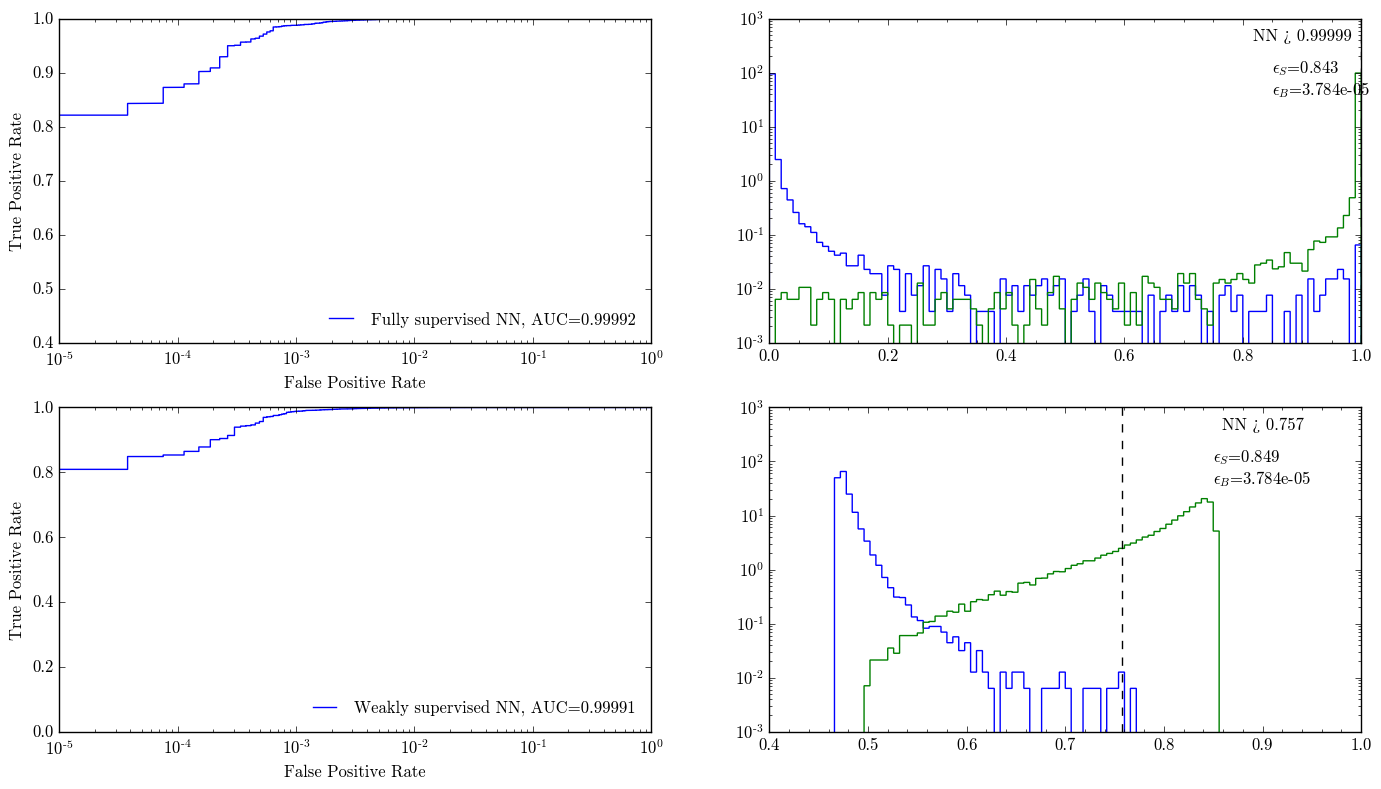

In [32]:
plt.figure(figsize=(8.4*2,4.6*2))
plt.subplot(2,2,1)
plt.plot(fprFull_1st,tprFull_1st,label='Fully supervised NN, AUC={0:.5f}'.format(auc_scoreFull_1st))
plt.legend(loc='lower right',frameon=False,fontsize=12)
plt.xscale('log')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.ylim(1e-6,1)

plt.subplot(2,2,2)
plt.hist(FullTestPredictions[test_y_1st==0],bins=100,range=(0,1),normed=True,histtype='step')
plt.hist(FullTestPredictions[test_y_1st==1],bins=100,range=(0,1),normed=True,histtype='step')
plt.yscale('log')
plt.xlim(0,1)
plt.ylim(1e-3,1e3)
plt.vlines(FullThresholdSet,1e-3,1e3,linestyle='--')

plt.text(.9,400,"NN > {0:.5f}".format(FullThresholdSet),ha='center')
plt.text(0.85,100,r'$\epsilon_{S}$'+'={0:.3f}'.format(float(sum(FullTestPredictions[test_y_1st==1]>FullThresholdSet)[0])/sum(test_y_1st==1))
        ,ha='left')
plt.text(0.85,40,r'$\epsilon_{B}$'+'={0:.3e}'.format(float(sum(FullTestPredictions[test_y_1st==0]>FullThresholdSet)[0])/sum(test_y_1st==0))
        ,ha='left')
plt.minorticks_on()

#######################
plt.subplot(2,2,3)
plt.plot(fprWeak_1st,tprWeak_1st,label='Weakly supervised NN, AUC={0:.5f}'.format(auc_scoreWeak_1st))
plt.legend(loc='lower right',frameon=False,fontsize=12)
plt.xscale('log')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.ylim(1e-6,1)

plt.subplot(2,2,4)
plt.hist(WeakTestPredictions[test_y_1st==0],bins=100,range=(.4,1),normed=True,histtype='step')
plt.hist(WeakTestPredictions[test_y_1st==1],bins=100,range=(.4,1),normed=True,histtype='step')
plt.yscale('log')
plt.xlim(.4,1)
plt.ylim(1e-3,1e3)
plt.vlines(WeakThresholdSet_1st,1e-3,1e3,linestyle='--')

plt.text(.9,400,"NN > {0:.3f}".format(WeakThresholdSet_1st),ha='center')
plt.text(0.85,100,r'$\epsilon_{S}$'+'={0:.3f}'.format(float(sum(WeakTestPredictions[test_y_1st==1]>WeakThresholdSet_1st)[0])/sum(test_y_1st==1))
        ,ha='left')
plt.text(0.85,40,r'$\epsilon_{B}$'+'={0:.3e}'.format(float(sum(WeakTestPredictions[test_y_1st==0]>WeakThresholdSet_1st)[0])/sum(test_y_1st==0))
        ,ha='left')
plt.minorticks_on()
# plt.savefig('/Users/bryan/Dropbox/AWorkToUpdate/WeakSupervision/Figs/Z-Jets/WeakLearning.pdf',bbox_inches='tight')
plt.show()

We see that the Fully supervised network has a slightly beter AUC, but that for a $\epsilon_B=3.78\text{e}-05$, the Weakly supervised actually allows more signal through. This test is using Monte Carlo generated background that does not extend up to large values of missing energy (not enough events are created). To alleviate this, we test the models against a background set that is created with weighted events to get a larger range of coverage.

## Load the weighted events

In [23]:
ZJet_weighted = pd.read_csv('Z_Jets_data_with_weights_1.txt',dtype=float)
X_z_scaled = scaler1st.transform(ZJet_weighted[x_cols])

In [24]:
# Predictions
Full_Weighted_predictions = FullySupervisedModel.predict_proba(X_z_scaled)
Weak_Weighted_predictions = WeaklySupervisedModel.predict_proba(X_z_scaled)

# GluinoPairProduction
GluinoFull = FullySupervisedModel.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))
GluinoWeak = WeaklySupervisedModel.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))

871488/875532 [============================>.] - ETA: 0s

Make a plot of the differential cross section with respect to the Neural Net Output and the missing energy.

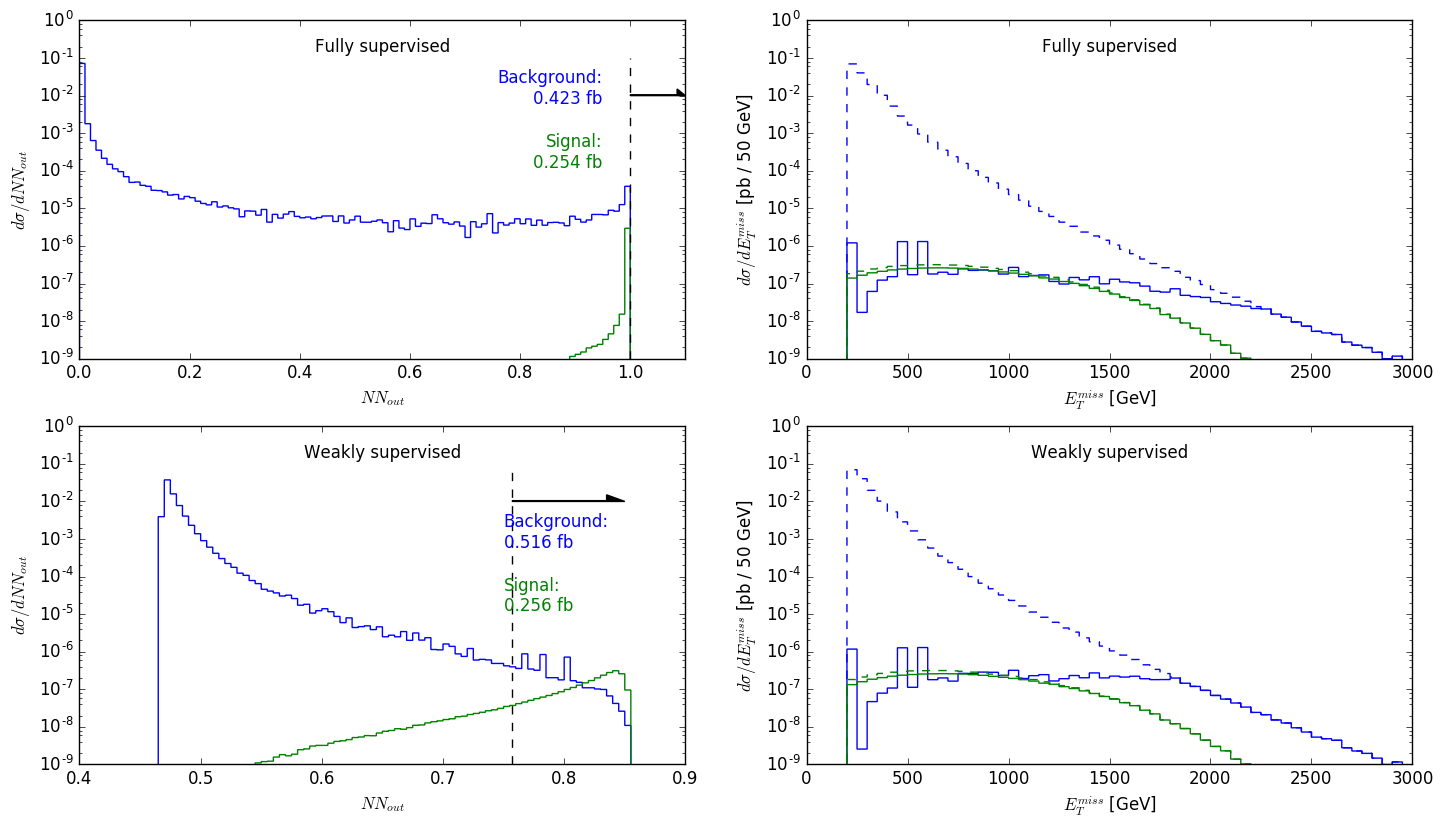

In [26]:
#Weak model surviving cross sections
backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions>WeakThresholdSet_1st]['weight'].sum()*1000
gluinoxs_Weak=Gluinos_1stGen[GluinoWeak>WeakThresholdSet_1st]['weight'].sum()*1000

# Full model survivng cross sections
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThresholdSet]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull>FullThresholdSet]['weight'].sum()*1000


plt.figure(figsize=(8.6*2,4.8*2))

#*********************
#FullModel - NNout
#*********************
plt.subplot(2,2,1)

plt.hist(Full_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(GluinoFull,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.vlines(FullThresholdSet,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThresholdSet_1st,1e-2,.9-WeakThresholdSet_1st,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
plt.arrow(FullThresholdSet,1e-2,1.1-FullThresholdSet,0,length_includes_head=True,
          head_width=0.01,fc='black',shape='right')



plt.text(0.95,5e-2,"Background:\n{0:.3f} fb".format(backgroundxs_Full),va='top',color='blue',ha='right')
plt.text(0.95,1e-3,"Signal:\n{0:.3f} fb".format(gluinoxs_Full),va='top',color='green',ha='right')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(0,1.1)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text(1.1/2,0.2,"Fully supervised",ha='center',va='center')

#*********************
#FullModel - MET
#*********************
plt.subplot(2,2,2)

plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Full_Weighted_predictions>FullThresholdSet]['MET'],
         weights=ZJet_weighted[Full_Weighted_predictions>FullThresholdSet]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoFull > FullThresholdSet]['MET'],
         weights=Gluinos_1stGen[GluinoFull > FullThresholdSet]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,"Fully supervised",ha='center',va='center')


#*********************
#WeakModel - NNout
#*********************
plt.subplot(2,2,3)
plt.hist(Weak_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.hist(GluinoWeak,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.vlines(WeakThresholdSet_1st,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThresholdSet_1st,1e-2,.9-WeakThresholdSet_1st,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
plt.arrow(WeakThresholdSet_1st,1e-2,.85-WeakThresholdSet_1st,0,length_includes_head=True,
          head_width=0.01,fc='black',shape='right')



plt.text(0.75,5e-3,"Background:\n{0:.3f} fb".format(backgroundxs_Weak),va='top',color='blue')
plt.text(0.75,1e-4,"Signal:\n{0:.3f} fb".format(gluinoxs_Weak),va='top',color='green')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(.4,.9)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text((.4+.9)/2,0.2,"Weakly supervised",ha='center',va='center')

#*********************
#WeakModel - MET
#*********************
plt.subplot(2,2,4)
plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Weak_Weighted_predictions > WeakThresholdSet_1st]['MET'],
         weights=ZJet_weighted[Weak_Weighted_predictions > WeakThresholdSet_1st]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoWeak > WeakThresholdSet_1st]['MET'],
         weights=Gluinos_1stGen[GluinoWeak > WeakThresholdSet_1st]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,"Weakly supervised",ha='center',va='center')


#****************
# Final part
#****************

# plt.savefig('/Users/bryan/Dropbox/AWorkToUpdate/WeakSupervision/Figs/Z-Jets/Comparison.pdf',format='pdf',bbox_inches='tight')
plt.show()

That seems to work well for both networks. Now that we have more statistics, let's up the cut on the neural network output.

In [25]:
x = np.linspace(.81,.87,50)
weak_xs_diff=[]
for xi in x:
    gluino_weak_xs = Gluinos_1stGen[GluinoWeak>xi]['weight'].sum()*1000
    background_weak_xs = ZJet_weighted[Weak_Weighted_predictions>xi]['weight'].sum()*1000
    weak_xs_diff.append(background_weak_xs-gluino_weak_xs)
WeakThreshold_New = .81#x[np.argmin(np.abs(weak_xs_diff))]
gluinoxs_Weak=Gluinos_1stGen[GluinoWeak>WeakThreshold_New]['weight'].sum()*1000
backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions>WeakThreshold_New]['weight'].sum()*1000
print "The threshold is: {0}".format(WeakThreshold_New)
print "The cross section for signal is then:    {0} fb".format(gluinoxs_Weak)
print "The cross section for background is then {0} fb".format(backgroundxs_Weak)

The threshold is: 0.81
The cross section for signal is then:    0.183657482918 fb
The cross section for background is then 0.0720331484041 fb


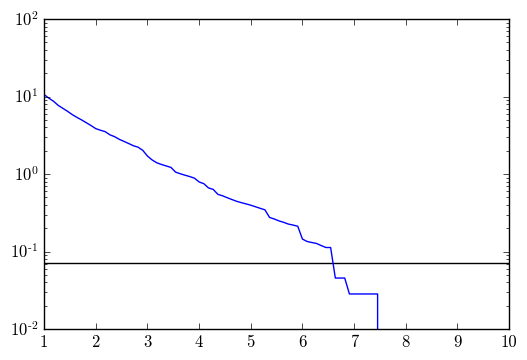

0.999999768987 0.81


In [26]:
x = np.linspace(1,10,100)
y = []
xt=[]
for xi in x:
    xt.append(2 - np.exp(10**(-xi)))
    y.append(ZJet_weighted[Full_Weighted_predictions>xt[-1]]['weight'].sum()*1000 )
minval = np.argmin(abs(np.array(y)-backgroundxs_Weak))
plt.plot(x,y)
plt.hlines(backgroundxs_Weak,1,10)
plt.yscale('log')
plt.show()

FullThreshold_New = xt[minval]
print FullThreshold_New, WeakThreshold_New

In [27]:
# Full model survivng cross sections
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull>FullThreshold_New]['weight'].sum()*1000

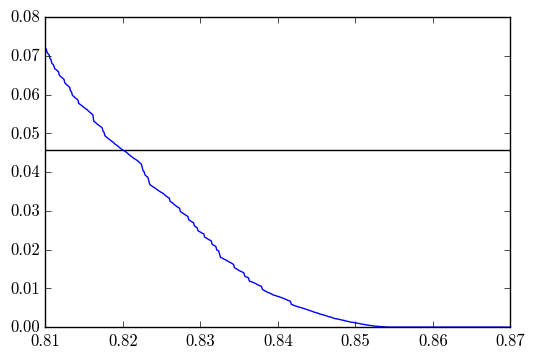

The threshold is: 0.820100200401
The cross section for signal is then:    0.155562980196 fb
The cross section for background is then 0.045583332044 fb


In [28]:
x = np.linspace(.81,.87,500)
weak_b_background=[]
for xi in x:
    gluino_weak_xs = Gluinos_1stGen[GluinoWeak>xi]['weight'].sum()*1000
    background_weak_xs = ZJet_weighted[Weak_Weighted_predictions>xi]['weight'].sum()*1000
    weak_b_background.append(background_weak_xs)

plt.plot(x,weak_b_background)
plt.hlines(backgroundxs_Full,.81,.87)
plt.show()

WeakThreshold_New = x[np.argmin(abs(np.array(weak_b_background)-backgroundxs_Full))]

#Weak model surviving cross sections

gluinoxs_Weak=Gluinos_1stGen[GluinoWeak>WeakThreshold_New]['weight'].sum()*1000
backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions>WeakThreshold_New]['weight'].sum()*1000
print "The threshold is: {0}".format(WeakThreshold_New)
print "The cross section for signal is then:    {0} fb".format(gluinoxs_Weak)
print "The cross section for background is then {0} fb".format(backgroundxs_Weak)

In [29]:
1-FullThreshold_New

2.3101299673200515e-07

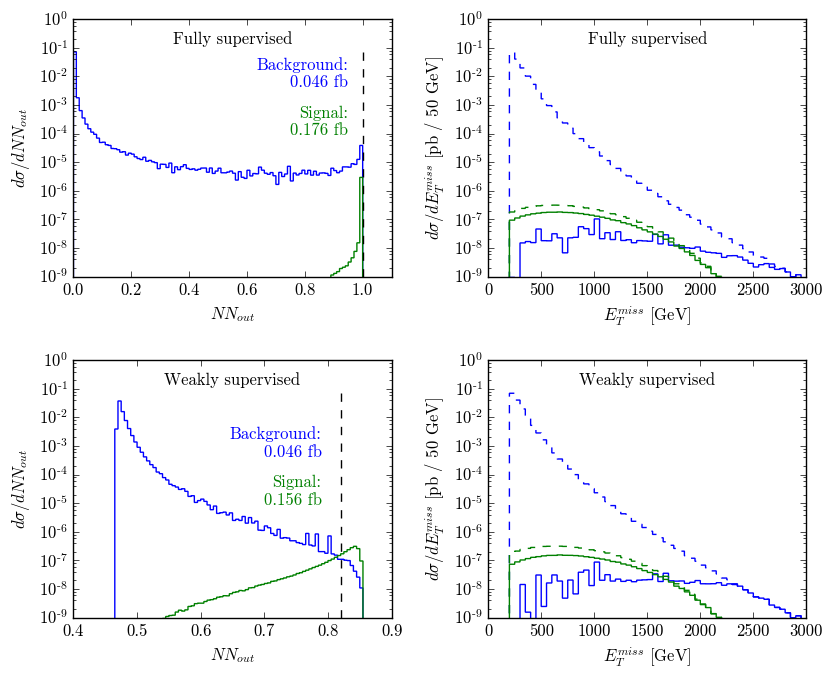

In [29]:
plt.figure(figsize=(8.5,7))

#*********************
#FullModel - NNout
#*********************
plt.subplot(2,2,1)

plt.hist(Full_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(GluinoFull,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.vlines(FullThreshold_New,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
# plt.arrow(FullThreshold_New,1e-2,1.05-FullThreshold_New,0,length_includes_head=True,
#           head_width=0.01,fc='black',shape='right')



plt.text(0.95,5e-2,"Background:\n{0:.3f} fb".format(backgroundxs_Full),va='top',color='blue',ha='right')
plt.text(0.95,1e-3,"Signal:\n{0:.3f} fb".format(gluinoxs_Full),va='top',color='green',ha='right')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(0,1.1)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text(1.1/2,0.2,"Fully supervised",ha='center',va='center')

#*********************
#FullModel - MET
#*********************
plt.subplot(2,2,2)

plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['MET'],
         weights=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoFull > FullThreshold_New]['MET'],
         weights=Gluinos_1stGen[GluinoFull > FullThreshold_New]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,"Fully supervised",ha='center',va='center')


#*********************
#WeakModel - NNout
#*********************
plt.subplot(2,2,3)
plt.hist(Weak_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.hist(GluinoWeak,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.vlines(WeakThreshold_New,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
# plt.arrow(WeakThreshold_New,1e-2,.85-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.01,fc='black',shape='right')



plt.text(0.79,5e-3,"Background:\n{0:.3f} fb".format(backgroundxs_Weak),va='top',color='blue',ha='right')
plt.text(0.79,1e-4,"Signal:\n{0:.3f} fb".format(gluinoxs_Weak),va='top',color='green',ha='right')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(.4,.9)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text((.4+.9)/2,0.2,"Weakly supervised",ha='center',va='center')

#*********************
#WeakModel - MET
#*********************
plt.subplot(2,2,4)
plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Weak_Weighted_predictions > WeakThreshold_New]['MET'],
         weights=ZJet_weighted[Weak_Weighted_predictions > WeakThreshold_New]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoWeak > WeakThreshold_New]['MET'],
         weights=Gluinos_1stGen[GluinoWeak > WeakThreshold_New]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,r"Weakly supervised",ha='center',va='center')


#****************
# Final part
#****************
plt.tight_layout()
plt.savefig('/Users/bryan/Desktop/MET_Comparison.pdf',format='pdf',bbox_inches='tight')


## Pseudo mis-modeling
Let some of the events in the signal sample get labeled as background and some of the background get labeled as signal. Re-train and then see how the results compare.

In [30]:
# let ~ 10% of the events get re-classified.
LowerFlipThreshold = thresh_1st[np.argmin(abs(fprFull_1st - 0.15))]
UpperFlipThreshold = thresh_1st[np.argmin(abs((1-tprFull_1st) - 0.16))]
print LowerFlipThreshold, UpperFlipThreshold

0.00396484 0.999987


In [31]:
y_flipped = np.zeros(len(x_train_1st))
# random_nums = np.random.random(len(y_flipped))
background_flipped = 0
signal_flipped = 0
# Check the backgrounds. If output divided by the threshold set above is greater than the random number, then flip
for i in range(len(y_flipped)):
    if Y_TRAIN_1st[i]==0:
        if  FullTrainPredictions[i]/LowerFlipThreshold > 1: 
            y_flipped[i]=1
            background_flipped+=1
    if Y_TRAIN_1st[i]==1:
        if (1-FullTrainPredictions[i])/(1-UpperFlipThreshold)>1: 
            y_flipped[i]=1
            signal_flipped +=1
#     if i%(len(Y_TRAIN_1st)/50) ==0:
#         print i, float(i)/len(Y_TRAIN_1st)
print
print float(sum(y_flipped)) / len(y_flipped) * 100, '% of the events got flipped'
print signal_flipped, float(signal_flipped) / sum(Y_TRAIN_1st==1)
print background_flipped, float(background_flipped) / sum(Y_TRAIN_1st==0)

train_flipped = abs(Y_TRAIN_1st - y_flipped)


15.0439545336 % of the events got flipped
54497 0.159907629921
25404 0.13348466219


In [32]:
sum(abs(train_flipped - Y_TRAIN_1st))

79901.0

In [33]:
y_flipped_valid = np.zeros(len(x_valid_1st))
# random_nums_valid = np.random.random(len(y_flipped_valid))
background_flipped_valid = 0
signal_flipped_valid = 0
# Check the backgrounds. If output divided by the threshold set above is greater than the random number, then flip
for i in range(len(y_flipped_valid)):
    if Y_VALID_1st[i]==0:
        if  FullValidPredictions[i]/LowerFlipThreshold > 1: 
            y_flipped_valid[i]=1
            background_flipped_valid+=1
    if Y_VALID_1st[i]==1:
        if (1-FullValidPredictions[i])/(1-UpperFlipThreshold) > 1: 
            y_flipped_valid[i]=1
            signal_flipped_valid +=1
#     if i%(len(Y_TRAIN_1st)/50) ==0:
#         print i, float(i)/len(Y_TRAIN_1st)
print
print float(sum(y_flipped_valid)) / len(y_flipped_valid) * 100, '% of the events got flipped'
print signal_flipped_valid, float(signal_flipped_valid) / sum(Y_VALID_1st==1)
print background_flipped_valid, float(background_flipped_valid) / sum(Y_VALID_1st==0)

valid_flipped = abs(Y_VALID_1st - y_flipped_valid)


14.9894562434 % of the events got flipped
13661 0.16030086481
6242 0.131247503101


Quick histogram of the flipping

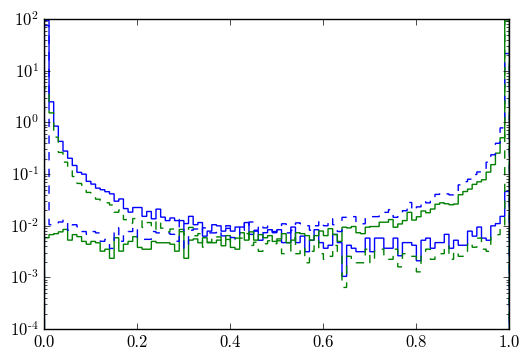

In [34]:
plt.hist(FullTrainPredictions[Y_TRAIN_1st==0], range=(0,1),bins=100,normed=True,histtype='step')
plt.hist(FullTrainPredictions[Y_TRAIN_1st==1], range=(0,1),bins=100,normed=True,histtype='step')

plt.hist(FullTrainPredictions[train_flipped==0],range=(0,1),bins=100,normed=True,histtype='step',color='blue',linestyle='--')
plt.hist(FullTrainPredictions[train_flipped==1],range=(0,1),bins=100,normed=True,histtype='step',color='green',linestyle='--')

plt.yscale('log')
plt.show()

Now split the data up into A and B sets in the same way as before.

In [35]:
length_0_1st_Mislabel = sum(train_flipped==0)
length_1_1st_Mislabel = sum(train_flipped==1)
# Set A: 80% of total background and 40% of total signal
set_a_0_Mislabel = x_train_1st[train_flipped==0][:int(0.8*length_0_1st_Mislabel)]
set_a_1_Mislabel = x_train_1st[train_flipped==1][:int(0.4*length_1_1st_Mislabel)]
percentage_a_Mislabel = (0.4*length_1_1st_Mislabel)/(0.4*length_1_1st_Mislabel+0.8*length_0_1st_Mislabel)
print "Percentage of signal for set A:", percentage_a_Mislabel
set_a_Mislabel = np.vstack([set_a_0_Mislabel,set_a_1_Mislabel])
set_a_percentages_Mislabel = np.ones(set_a_Mislabel.shape[0])*percentage_a_Mislabel
set_a_truth_Mislabel = np.append(np.zeros(int(0.8*length_0_1st_Mislabel)),np.ones(int(0.4*length_1_1st_Mislabel)))
print len(set_a_truth_Mislabel),len(set_a_Mislabel),len(set_a_percentages_Mislabel)

Percentage of signal for set A: 0.415323160885
300209 300209 300209


In [36]:
# Set B: 80% of total background and 40% of total signal
set_b_0_Mislabel = x_train_1st[train_flipped==0][int(0.8*length_0_1st_Mislabel):]
set_b_1_Mislabel = x_train_1st[train_flipped==1][int(0.4*length_1_1st_Mislabel):]
percentage_b_Mislabel = (0.6*length_1_1st_Mislabel)/(0.6*length_1_1st_Mislabel+0.2*length_0_1st_Mislabel)
print "Percentage of signal for set B:", percentage_b_Mislabel
set_b_Mislabel = np.vstack([set_b_0_Mislabel,set_b_1_Mislabel])
set_b_percentages_Mislabel = np.ones(set_b_Mislabel.shape[0])*percentage_b_Mislabel
set_b_truth_Mislabel = np.append(np.zeros(length_0_1st_Mislabel-int(0.8*length_0_1st_Mislabel)),
                                 np.ones(length_1_1st_Mislabel-int(0.4*length_1_1st_Mislabel)))
print len(set_b_truth_Mislabel),len(set_b_Mislabel),len(set_b_percentages_Mislabel)

Percentage of signal for set B: 0.809961049321
230908 230908 230908


In [37]:
# Validation Set
length_0_1st_Mislabel_v = sum(valid_flipped==0)
length_1_1st_Mislabel_v = sum(valid_flipped==1)
# Set A: 80% of total background and 40% of total signal
set_a_0_Mislabel_v = x_valid_1st[valid_flipped==0][:int(0.8*length_0_1st_Mislabel_v)]
set_a_1_Mislabel_v = x_valid_1st[valid_flipped==1][:int(0.4*length_1_1st_Mislabel_v)]
percentage_a_Mislabel_v = (0.4*length_1_1st_Mislabel_v)/(0.4*length_1_1st_Mislabel_v+0.8*length_0_1st_Mislabel_v)
print "Percentage of signal for set A:", percentage_a_Mislabel_v
set_a_Mislabel_v = np.vstack([set_a_0_Mislabel_v,set_a_1_Mislabel_v])
set_a_percentages_Mislabel_v = np.ones(set_a_Mislabel_v.shape[0])*percentage_a_Mislabel_v
set_a_truth_Mislabel_v = np.append(np.zeros(int(0.8*length_0_1st_Mislabel_v)),np.ones(int(0.4*length_1_1st_Mislabel_v)))
print len(set_a_truth_Mislabel_v),len(set_a_Mislabel_v),len(set_a_percentages_Mislabel_v)

# Set B: 80% of total background and 40% of total signal
set_b_0_Mislabel_v = x_valid_1st[valid_flipped==0][int(0.8*length_0_1st_Mislabel_v):]
set_b_1_Mislabel_v = x_valid_1st[valid_flipped==1][int(0.4*length_1_1st_Mislabel_v):]
percentage_b_Mislabel_v = (0.6*length_1_1st_Mislabel_v)/(0.6*length_1_1st_Mislabel_v+0.2*length_0_1st_Mislabel_v)
print "Percentage of signal for set B:", percentage_b_Mislabel_v
set_b_Mislabel_v = np.vstack([set_b_0_Mislabel_v,set_b_1_Mislabel_v])
set_b_percentages_Mislabel_v = np.ones(set_b_Mislabel_v.shape[0])*percentage_b_Mislabel_v
set_b_truth_Mislabel_v = np.append(np.zeros(length_0_1st_Mislabel_v-int(0.8*length_0_1st_Mislabel_v)),
                                 np.ones(length_1_1st_Mislabel_v-int(0.4*length_1_1st_Mislabel_v)))
print len(set_b_truth_Mislabel_v),len(set_b_Mislabel_v),len(set_b_percentages_Mislabel_v)

Percentage of signal for set A: 0.414373821621
75102 75102 75102
Percentage of signal for set B: 0.809358355526
57678 57678 57678


### Train the networks: Fully supervised

In [38]:
PseudoMisModelFull = Sequential()
PseudoMisModelFull.add(Dense(30, activation="sigmoid", kernel_initializer="normal", input_dim=11))
PseudoMisModelFull.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
PseudoMisModelFull.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01))

In [39]:
# On the first run, uncomment the next two lines. This will train the model and save the results
# PseudoMisModelFull.fit(x_train_1st,
#                        train_flipped,
#                        validation_data=(x_valid_1st,valid_flipped))
# PseudoMisModelFull.save('PseudoMisModelFull.h5')
PseudoMisModelFull.load_weights('PseudoMisModelFull.h5')

### Weakly supervised

In [40]:
PseduoMisModelWeak = Sequential()
PseduoMisModelWeak.add(Dense(30, activation="sigmoid", kernel_initializer="normal", input_dim=11))
PseduoMisModelWeak.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
PseduoMisModelWeak.compile(loss=WeakSupervision,optimizer=Adam(lr=0.00001))

In [41]:
# On the first run, uncomment the next lines. This will train the model and save the results
# PseduoMisModelWeak.fit(X_Train_1st, 
#                        np.append(set_a_percentages_Mislabel,set_b_percentages_Mislabel), 
#                        validation_data=(X_Valid_1st,
#                                         np.append(set_a_percentages_Mislabel_v,set_b_percentages_Mislabel_v)
#                                        ),    
#                        batch_size=32, epochs=10)
# PseduoMisModelWeak.save('PseduoMisModelWeak.h5')
PseduoMisModelWeak.load_weights('PseduoMisModelWeak.h5')

### Now plot the results of the training

In [42]:
PseduoFullTestPreds = PseudoMisModelFull.predict_proba(x_test_1st)
PseduoWeakTestPreds = PseduoMisModelWeak.predict_proba(x_test_1st)

72320/73765 [============================>.] - ETA: 0s

In [43]:
fprFull_Pseudo, tprFull_Pseudo, thresh_Pseudo = metrics.roc_curve(test_y_1st,PseduoFullTestPreds)
auc_PseudoFull = metrics.auc(fprFull_Pseudo,tprFull_Pseudo)
print auc_PseudoFull, ", Old score was:",auc_scoreFull_1st

fprWeak_Pseduo, tprWeak_Pseduo, threshWeak_Pseduo = metrics.roc_curve(test_y_1st,PseduoWeakTestPreds)
auc_scoreWeak_Pseduo = metrics.auc(fprWeak_Pseduo,tprWeak_Pseduo)
print auc_scoreWeak_Pseduo, ", Old score was:",auc_scoreWeak_1st

0.940646393364 , Old score was: 0.999921286204
0.999910855883 , Old score was: 0.99990906181


In [44]:
print "Mis-classification led to a change of {0:.5f}% in the Fully supervised network".format(
    (auc_scoreFull_1st-auc_PseudoFull)/auc_scoreFull_1st*100)
print "Mis-classification led to a change of {0:.5f}% in the Weakly supervised network".format(
    (auc_scoreWeak_1st-auc_scoreWeak_Pseduo)/auc_scoreWeak_1st*100)

Mis-classification led to a change of 5.92796% in the Fully supervised network
Mis-classification led to a change of -0.00018% in the Weakly supervised network


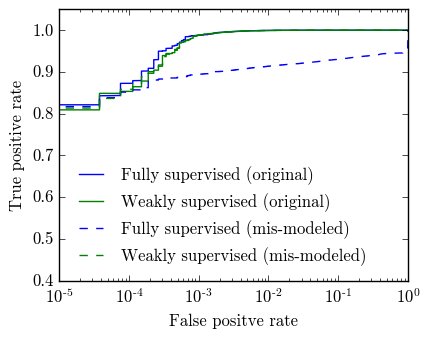

In [45]:
plt.figure(figsize=(4.5,3.5))
plt.plot(fprFull_1st,tprFull_1st, label='Fully supervised (original)')
plt.plot(fprWeak_1st,tprWeak_1st, label='Weakly supervised (original)')

plt.plot(fprFull_Pseudo,tprFull_Pseudo,color='blue',linestyle='--', label='Fully supervised (mis-modeled)')
plt.plot(fprWeak_Pseduo, tprWeak_Pseduo, color='green',linestyle='--', label='Weakly supervised (mis-modeled)')

# plt.xlim(-0.1,1.1)
plt.ylim(.4,1.05)
plt.xscale('log')
plt.legend(loc='lower left', frameon=False, fontsize=12)
plt.xlabel('False positve rate')
plt.ylabel('True positive rate')
plt.savefig('/Users/bryan/Desktop/mismodeled.pdf',bbox_inches='tight')
plt.show()

In [46]:
# Predictions
Full_Weighted_predictions_Pseudo = PseudoMisModelFull.predict_proba(X_z_scaled)
Weak_Weighted_predictions_Pseudo = PseduoMisModelWeak.predict_proba(X_z_scaled)

# GluinoPairProduction
GluinoFull_Pseudo = PseudoMisModelFull.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))
GluinoWeak_Pseudo = PseduoMisModelWeak.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))

875532/875532 [==============================] - 11s    


In [47]:
pseduoThreshNum = np.mean([1,np.mean([max(thresh_Pseudo),thresh_Pseudo[np.argmin(abs(tprFull_Pseudo - 0.832))]])])
pseduoThreshNumWeak = np.mean([max(threshWeak_Pseduo),np.mean([max(threshWeak_Pseduo),threshWeak_Pseduo[np.argmin(abs(tprWeak_Pseduo - 0.832))]])])
print pseduoThreshNum, pseduoThreshNumWeak

0.8931427598 0.798393


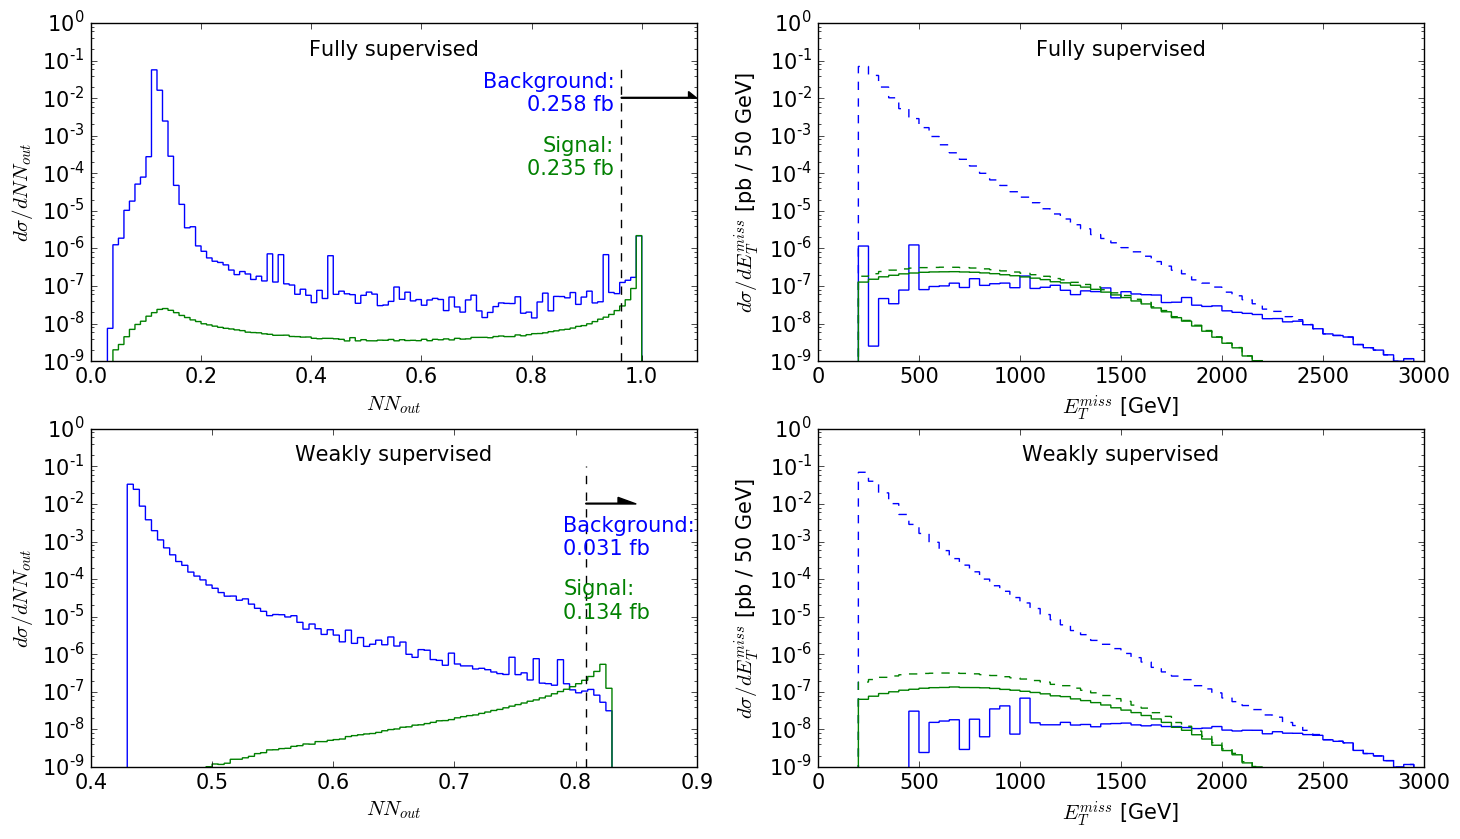

In [515]:
#Weak model surviving cross sections
backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions_Pseudo>pseduoThreshNumWeak]['weight'].sum()*1000
gluinoxs_Weak=Gluinos_1stGen[GluinoWeak_Pseudo>pseduoThreshNumWeak]['weight'].sum()*1000

# Full model survivng cross sections
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions_Pseudo>pseduoThreshNum]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull_Pseudo>pseduoThreshNum]['weight'].sum()*1000


plt.figure(figsize=(8.6*2,4.8*2))

#*********************
#FullModel - NNout
#*********************
plt.subplot(2,2,1)

plt.hist(Full_Weighted_predictions_Pseudo,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(GluinoFull_Pseudo,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.vlines(pseduoThreshNum,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
plt.arrow(pseduoThreshNum,1e-2,1.1-pseduoThreshNum,0,length_includes_head=True,
          head_width=0.01,fc='black',shape='right')



plt.text(0.95,5e-2,"Background:\n{0:.3f} fb".format(backgroundxs_Full),va='top',color='blue',ha='right')
plt.text(0.95,1e-3,"Signal:\n{0:.3f} fb".format(gluinoxs_Full),va='top',color='green',ha='right')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(0,1.1)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text(1.1/2,0.2,"Fully supervised",ha='center',va='center')

#*********************
#FullModel - MET
#*********************
plt.subplot(2,2,2)

plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Full_Weighted_predictions_Pseudo>pseduoThreshNum]['MET'],
         weights=ZJet_weighted[Full_Weighted_predictions_Pseudo>pseduoThreshNum]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoFull_Pseudo > pseduoThreshNum]['MET'],
         weights=Gluinos_1stGen[GluinoFull_Pseudo > pseduoThreshNum]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,"Fully supervised",ha='center',va='center')


#*********************
#WeakModel - NNout
#*********************
plt.subplot(2,2,3)
plt.hist(Weak_Weighted_predictions_Pseudo,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.hist(GluinoWeak_Pseudo,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.vlines(pseduoThreshNumWeak,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
plt.arrow(pseduoThreshNumWeak,1e-2,.85-pseduoThreshNumWeak,0,length_includes_head=True,
          head_width=0.01,fc='black',shape='right')



plt.text(0.79,5e-3,"Background:\n{0:.3f} fb".format(backgroundxs_Weak),va='top',color='blue')
plt.text(0.79,1e-4,"Signal:\n{0:.3f} fb".format(gluinoxs_Weak),va='top',color='green')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(.4,.9)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text((.4+.9)/2,0.2,"Weakly supervised",ha='center',va='center')

#*********************
#WeakModel - MET
#*********************
plt.subplot(2,2,4)
plt.hist(ZJet_weighted['MET'],
         weights=ZJet_weighted['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue',
         ls='--'
        )
plt.hist(ZJet_weighted[Weak_Weighted_predictions_Pseudo > pseduoThreshNumWeak]['MET'],
         weights=ZJet_weighted[Weak_Weighted_predictions_Pseudo > pseduoThreshNumWeak]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='blue'
        )

plt.hist(Gluinos_1stGen[GluinoWeak_Pseudo > pseduoThreshNumWeak]['MET'],
         weights=Gluinos_1stGen[GluinoWeak_Pseudo > pseduoThreshNumWeak]['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green'
        )
plt.hist(Gluinos_1stGen['MET'],
         weights=Gluinos_1stGen['weight']/50,
         bins=60,range=(200,3200),
         histtype='step',
         color='green',
         ls='--'
        )

plt.yscale('log')
plt.ylim(1e-9,1)
plt.ylabel(r'$d\sigma/dE_T^{miss}$ [pb / 50 GeV]')
plt.xlabel(r'$E_T^{miss}$ [GeV]')
plt.xlim(0,3000)
plt.text(1500,0.2,"Weakly supervised",ha='center',va='center')


#****************
# Final part
#****************

# plt.savefig('/Users/bryan/Dropbox/AWorkToUpdate/WeakSupervision/Figs/Z-Jets/Comparison.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Check the models against different signals (gluino pair production with decays to 1st generation OR stop pair production)

In [48]:
# Load the 3rd generation decay
Gluinos_3rdGen = pd.read_csv('Gluino_r3.txt',dtype=float)
Gluinos_3rdGen_scaled = scaler1st.transform(Gluinos_3rdGen[x_cols])
print "Gluino_3 cross section: {0:.3f} fb".format(Gluinos_3rdGen['weight'].sum()*1000)

#Weak model predictions
pred_withWeightsGluino3_weak=WeaklySupervisedModel.predict_proba(Gluinos_3rdGen_scaled, verbose=1)

# Full model predictions
Full_Wieghted_predsGluino3=FullySupervisedModel.predict(Gluinos_3rdGen_scaled)

Gluino_3 cross section: 0.255 fb
399712/400844 [============================>.] - ETA: 0s

In [49]:
# Stops
Stops_weighted = pd.read_csv('STOPS_1TeV.txt',dtype=float)
X_Stops_scaled = scaler1st.transform(Stops_weighted[x_cols])
print "Stop cross section: {0:.3f} fb".format(Stops_weighted['weight'].sum()*1000)

#Weak model predictions
pred_withWeightsStops=WeaklySupervisedModel.predict_proba(X_Stops_scaled, verbose=1)

# Full model predictions
Full_Wieghted_predsStops=FullySupervisedModel.predict(X_Stops_scaled)

Stop cross section: 1.576 fb
352032/354714 [============================>.] - ETA: 0s

Plot the neuural network outputs

In [50]:
# predicitions from the original networks
Full_Weighted_predictions = FullySupervisedModel.predict_proba(X_z_scaled)
Weak_Weighted_predictions = WeaklySupervisedModel.predict_proba(X_z_scaled)

# GluinoPairProduction
GluinoFull = FullySupervisedModel.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))
GluinoWeak = WeaklySupervisedModel.predict(scaler1st.transform(Gluinos_1stGen[x_cols]))

874816/875532 [============================>.] - ETA: 0s

In [51]:
print FullThreshold_New, 1-FullThreshold_New
print WeakThreshold_New

0.999999768987 2.31012996732e-07
0.820100200401


In [52]:
#Weak model surviving cross sections
# backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions>WeakThreshold_New]['weight'].sum()*1000
gluinoxs_Weak=Gluinos_1stGen[GluinoWeak>WeakThreshold_New]['weight'].sum()*1000

# Full model survivng cross sections
# backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull>FullThreshold_New]['weight'].sum()*1000

print gluinoxs_Full, gluinoxs_Weak

0.176049497442 0.155562980196


In [53]:
# x = np.logspace(np.log(FullThreshold_New), 0,100)
# y = []
# for xi in x:
#     y.append(Gluinos_1stGen[GluinoFull>xi]['weight'].sum()*1000 - gluinoxs_Weak)
# minval = np.argmin(abs(np.array(y)))
# FullThreshold_New = x[minval]
# print FullThreshold_New

In [54]:
#Weak model surviving cross sections
backgroundxs_Weak=ZJet_weighted[Weak_Weighted_predictions>WeakThreshold_New]['weight'].sum()*1000
gluinoxs_Weak=Gluinos_1stGen[GluinoWeak>WeakThreshold_New]['weight'].sum()*1000
gluinoxs_Weak_3 = Gluinos_3rdGen[pred_withWeightsGluino3_weak > WeakThreshold_New]['weight'].sum()*1000
stopxs_Weak = Stops_weighted[pred_withWeightsStops > WeakThreshold_New]['weight'].sum()*1000

print backgroundxs_Weak, gluinoxs_Weak, gluinoxs_Weak_3, stopxs_Weak

# Full model survivng cross sections
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull>FullThreshold_New]['weight'].sum()*1000
gluinoxs_Full_3 = Gluinos_3rdGen[Full_Wieghted_predsGluino3>FullThreshold_New]['weight'].sum()*1000
stopxs_Full =Stops_weighted[Full_Wieghted_predsStops>FullThreshold_New]['weight'].sum()*1000

print backgroundxs_Full, gluinoxs_Full, gluinoxs_Full_3, stopxs_Full

0.045583332044 0.155562980196 0.105376410256 0.0116785438
0.045614121764 0.176049497442 0.118626157726 0.016480562


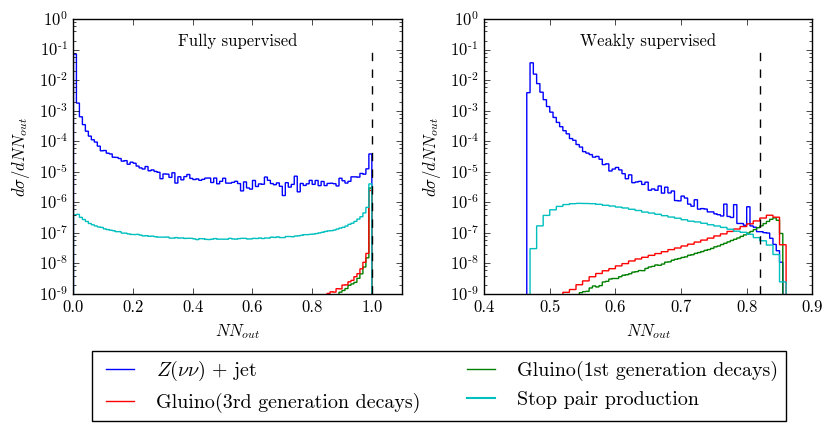

In [57]:
plt.figure(figsize=(8.5,3.7))
plt.subplot(1,2,1)

plt.hist(Full_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(GluinoFull,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(Full_Wieghted_predsGluino3,weights=Gluinos_3rdGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(Full_Wieghted_predsStops,weights=Stops_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )

plt.vlines(FullThreshold_New,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
# plt.arrow(FullThreshold_New,1e-2,1.05-FullThreshold_New,0,length_includes_head=True,
#           head_width=0.01,fc='black',shape='right')



# plt.text(0.95,5e-2,"Background:\n{0:.3f} fb".format(backgroundxs_Full),va='top',color='blue',ha='right')
# plt.text(0.95,1e-3,"Signal:\n{0:.3f} fb".format(gluinoxs_Full),va='top',color='green',ha='right')

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(0,1.1)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text(1.1/2,0.2,"Fully supervised",ha='center',va='center')

#*********************
#WeakModel - NNout
#*********************
plt.subplot(1,2,2)

plt.hist(Weak_Weighted_predictions,
         weights=ZJet_weighted['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.hist(GluinoWeak,weights=Gluinos_1stGen['weight']/100,
         bins=100,
         range=(.4,.9),
         histtype='step'
        )
plt.hist(pred_withWeightsGluino3_weak,weights=Gluinos_3rdGen['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )
plt.hist(pred_withWeightsStops,weights=Stops_weighted['weight']/100,
         bins=100,
         range=(0,1),
         histtype='step'
        )


plt.vlines(WeakThreshold_New,1e-9,1e-1,linestyles='--')
# plt.arrow(WeakThreshold_New,1e-2,.9-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.009,fc='black',shape='left')
# plt.arrow(WeakThreshold_New,1e-2,.85-WeakThreshold_New,0,length_includes_head=True,
#           head_width=0.01,fc='black',shape='right')

plt.plot([],[],color='blue',label=r'$Z(\nu\nu)$ + jet')
plt.plot([],[],color='red',label='Gluino(3rd generation decays)')
plt.plot([],[],color='green',label='Gluino(1st generation decays)')
plt.plot([],[],color='c',label='Stop pair production',lw=1.5)

plt.yscale('log')
plt.ylim(1e-9,1)
plt.xlim(.4,.9)
# plt.ylim(1e-10,1e-1)
plt.ylabel(r'$d\sigma/dNN_{out}$')
plt.xlabel(r'$NN_{out}$')
plt.text((.4+.9)/2,0.2,"Weakly supervised",ha='center',va='center')

plt.legend(bbox_to_anchor=(.95, -0.17),ncol=2)

plt.tight_layout()

plt.savefig('/Users/bryan/Desktop/AlternativeSignals.pdf',bbox_inches='tight')

## Using both neural network outputs together

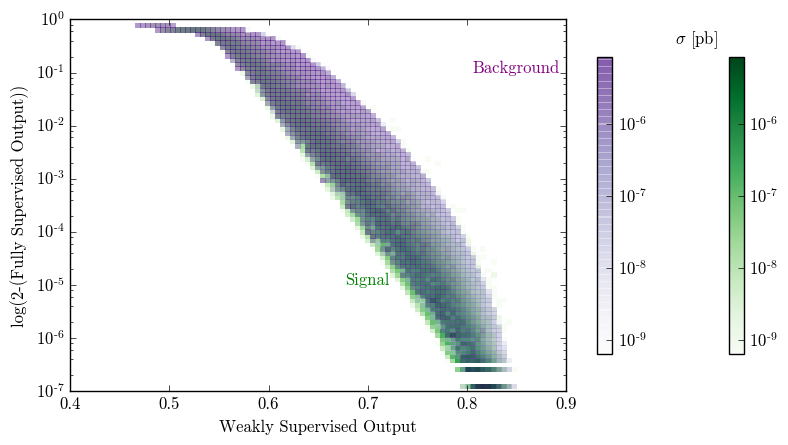

In [58]:
h,x,y = np.histogram2d(GluinoWeak.flatten(),np.log(2-GluinoFull).flatten(),
                       bins=[np.linspace(.4,.9,100),np.logspace(-8,0,100)],
                       weights=Gluinos_1stGen['weight']
                      )
h=h.T

hSM,xSM,ySM = np.histogram2d(Weak_Weighted_predictions.flatten(),np.log(2-Full_Weighted_predictions).flatten(),
                       bins=[np.linspace(.4,.9,100),np.logspace(-8,0,100)],
                       weights=ZJet_weighted['weight']
                      )
hSM=hSM.T

X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(10,4.8))
ax = fig.add_subplot(111)


c1=ax.pcolor(X, Y, h,cmap='Greens',norm=colors.LogNorm(vmin= h[h>0].min(), vmax= h.max()),alpha=1)
c2 =ax.pcolor(X, Y, hSM,cmap='Purples',norm=colors.LogNorm(vmin= h[h>0].min(), vmax= h.max()),alpha=0.4)
cbar1=fig.colorbar(c1,shrink=0.8)
cbar2=fig.colorbar(c2,shrink=0.8)
plt.text(1.01,.25,r'$\sigma$ [pb]',va='bottom')
plt.ylim(1e-7,1)
plt.xlim(.4,.9)
plt.yscale('log')
plt.xlabel('Weakly Supervised Output')
plt.ylabel('log(2-(Fully Supervised Output))')
plt.text(.85,.1,'Background',color='purple',ha='center',fontsize=12)
# plt.text(.65,1e-5,r'$\tilde{g}\tilde{g}$',color='green',ha='center',fontsize=12)
plt.text(.7,1e-5,'Signal',color='green',ha='center',fontsize=12)

# plt.savefig('/Users/bryan/Dropbox/AWorkToUpdate/WeakSupervision/Figs/Z-Jets/BothOutputs.pdf',bbox_inches='tight')
plt.show()

In [59]:
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight'].sum()*1000
gluinoxs_Full=Gluinos_1stGen[GluinoFull>FullThreshold_New]['weight'].sum()*1000

In [60]:
backgroundxs_Full

0.04561412176399906

In [61]:
firstZX=scaler1st.transform(ZJet[x_cols])

In [62]:
Z1_Full_pred = FullySupervisedModel.predict(firstZX)
Z1_Weak_pred = WeaklySupervisedModel.predict(firstZX)

In [63]:
BothFull = np.vstack([Full_Weighted_predictions,GluinoFull])
BothFull = BothFull - 1.0e-7
BothFull = np.log10(np.log(2-BothFull))
BothWeak = np.vstack([Weak_Weighted_predictions, GluinoWeak])

# BothFull = np.vstack([Z1_Full_pred,GluinoFull])
# BothFull = BothFull - 1.0e-7
# BothFull = np.log10(np.log(2-BothFull))
# BothWeak = np.vstack([Z1_Weak_pred, GluinoWeak])

In [64]:
BothX = np.hstack([BothWeak,BothFull])

scaler2 = StandardScaler()
BothX = scaler2.fit_transform(BothX)
BothY = np.append(np.zeros(len(Full_Weighted_predictions)),np.ones(len(GluinoFull)))
BothWeights = np.append(ZJet_weighted['weight'],Gluinos_1stGen['weight'])

GluinoCombinedX = scaler2.transform(np.hstack([GluinoWeak,np.log10(np.log(2-(GluinoFull-1e-7)))]))
BackgroundCombinedX = scaler2.transform(np.hstack([Weak_Weighted_predictions,np.log10(np.log(2-(Full_Weighted_predictions-1e-7)))]))

TotalBGXS = ZJet_weighted['weight'].sum()
TotalGluinoXS = Gluinos_1stGen['weight'].sum()
print "Total cross sections: {0:.2f}pb (background) and {1:.2f} fb (signal)".format(TotalBGXS, TotalGluinoXS*1000)
# BothWeights_train = np.append(
# #     np.log10(ZJet_weighted['weight']),
# #     np.log10(Gluinos_1stGen['weight'])
#     ZJet_weighted['weight'],
#     Gluinos_1stGen['weight']#*min(ZJet_weighted['weight'])/min(Gluinos_1stGen['weight'])
# )
# BothWeights_train = BothWeights_train/BothWeights_train.min()

# BothWeights_train = np.append(ZJet_weighted['weight'],
#                         Gluinos_1stGen['weight'])

BothWeights_train = np.append(
        ZJet_weighted['weight']/TotalBGXS * 1e4 * 100 ,
        Gluinos_1stGen['weight']/TotalGluinoXS * 1e4 
)

BothWeights_class={0:float(len(BothY))/sum(BothY==0),1:float(len(BothY))/sum(BothY==1)}
print BothWeights_train
print BothWeights_class

Total cross sections: 7.62pb (background) and 0.30 fb (signal)
[ 7.51426058  7.51426058  7.51426058 ...,  0.02112562  0.02112562
  0.02112562]
{0: 1.5406529972633782, 1: 2.8496151969224206}


In [62]:
np.unique(BothWeights_train)

array([  1.12708005e-04,   1.91156939e-03,   2.11256150e-02,
         9.44717677e-02,   7.51426058e+00])

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
import keras.callbacks

In [65]:
checkpointer = ModelCheckpoint('CombinedModel.h5',
                               monitor='val_loss',
                               save_best_only=True)
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto') 

In [66]:
CombinedModel= Sequential()
CombinedModel.add(Dense(30, 
                        kernel_initializer="normal",
                        activation="sigmoid", 
                        input_dim=2,
#                         kernel_regularizer=regularizers.l2(0.000001), 
                       )
                 )
CombinedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
CombinedModel.compile(loss='binary_crossentropy',optimizer=Adam(lr=.001))

Epoch 1/1
1348891/1348891 [==============================] - 6s - loss: 0.0091     

ModelSpecifics:  1 0 0 0.989949832916
Epoch 1/1
1348891/1348891 [==============================] - 6s - loss: 9.7831e-04     

ModelSpecifics:  2 0.169762811738 0.045330687256 0.991923921126
Epoch 1/1
1348891/1348891 [==============================] - 6s - loss: 5.9998e-04     

ModelSpecifics:  3 0.169808681354 0.045870507724 0.996938695508
Epoch 1/1
1348891/1348891 [==============================] - 6s - loss: 5.4158e-04     

ModelSpecifics:  4 0.167119575116 0.044847119364 0.997694945774
Epoch 1/1
1348891/1348891 [==============================] - 7s - loss: 5.2593e-04     

ModelSpecifics:  5 0.167039940366 0.04534498344 0.997597234833
Epoch 1/1
1348891/1348891 [==============================] - 7s - loss: 5.1724e-04     

ModelSpecifics:  6 0.166125733436 0.045416521404 0.997597234833
Epoch 1/1
1348891/1348891 [==============================] - 6s - loss: 5.1182e-04     

ModelSpecifics:  7 0.166

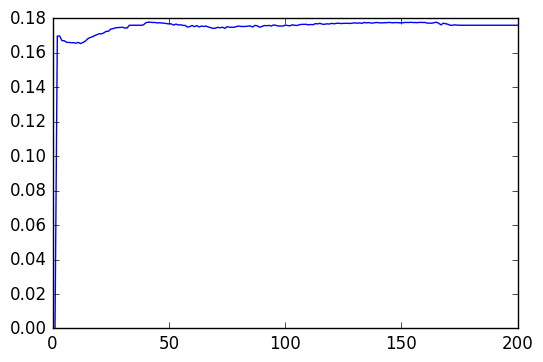

In [80]:
numberToRun = 200
numberRan = 0
SignalXS_Combine = []
modelnum=[]
batchsize = len(BothX)/2000
while numberRan < numberToRun:
    numberRan+=1
    
    CombinedModel.fit(BothX, 
                  BothY,
    #                   validation_split = 0.2,
#                       class_weight = BothWeights_class,
                      sample_weight = (BothWeights_train),
                      batch_size=batchsize,
                      epochs=1,
                      verbose=1,
    #                   callbacks=[checkpointer]
                     )
    # CombinedModel.load_weights('CombinedModel.h5')
    BothPreds = CombinedModel.predict_proba(BothX,batch_size=10000,verbose=0)
    GluinoCombinedPreds = CombinedModel.predict_proba(GluinoCombinedX,batch_size=10000,verbose=0)
    BackgroundCombinedPreds = CombinedModel.predict_proba(BackgroundCombinedX,batch_size=10000,verbose=0)
    
    x = np.linspace(2,5,2000)
    xt = []
    y = []
    for xi in x:
        xt.append(2 - np.exp(10**(-xi)))
        y.append( ZJet_weighted[BackgroundCombinedPreds>xt[-1]]['weight'].sum()*1000)
    #         Gluinos_1stGen[(GluinoCombinedPreds > xi)]['weight'].sum()*1000-gluinoxs_Weak)
    minval2 = np.argmin(abs(np.array(y)-0.0455))
    combinedThresh = xt[minval2]
    
    Background_Combined_XS = ZJet_weighted[BackgroundCombinedPreds>combinedThresh]['weight'].sum()*1000
    Signal_Combined_XS = Gluinos_1stGen[GluinoCombinedPreds>combinedThresh]['weight'].sum()*1000
    
    SignalXS_Combine.append(Signal_Combined_XS)
    modelnum.append(numberRan)
    
    CombinedModel.save('CombinedModels/m_b10_'+str(numberRan).zfill(3)+'.h5')
    print "\nModelSpecifics: ",numberRan, Signal_Combined_XS, Background_Combined_XS, combinedThresh
    
    xx, yy = np.meshgrid(np.arange(.4,.9, 0.02),
                         np.arange(-8, 0,.02))

    cm = plt.cm.RdBu
    Z = CombinedModel.predict(scaler2.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    plt.figure()
    hBack,xBack,yBack = np.histogram2d(scaler2.inverse_transform(BackgroundCombinedX)[:,0].flatten(),
                                       scaler2.inverse_transform(BackgroundCombinedX)[:,1].flatten(),
                                       bins=[np.linspace(.4,.9,100),np.linspace(-7,0,100)],
                                       weights=ZJet_weighted['weight']/100**2
                                      )

    hSig,xSig,ySig = np.histogram2d(scaler2.inverse_transform(GluinoCombinedX)[:,0].flatten(),
                                    scaler2.inverse_transform(GluinoCombinedX)[:,1].flatten(),
                                    bins=[np.linspace(.4,.9,100),np.linspace(-7,0,100)],
                                    weights=Gluinos_1stGen['weight']/100**2
                                    )
    hBack=hBack.T
    hSig = hSig.T

    fig = plt.figure(figsize=(10,4.8))
    ax = fig.add_subplot(111)

    c1 =ax.pcolor(xSig, ySig, hSig,cmap='Greens',norm=colors.LogNorm(vmin= hSig[hSig>0].min(),
                                                                     vmax= hSig.max()),alpha=0.75)
    c2 =ax.pcolor(xBack, yBack, hBack,cmap='Purples',norm=colors.LogNorm(vmin= hSig[hSig>0].min(),
                                                                         vmax= hSig.max()),alpha=0.4)


    cbar1=fig.colorbar(c1,shrink=0.8)
    cbar2=fig.colorbar(c2,shrink=0.8)

    plt.contour(xx, yy, Z, cmap="copper")
    plt.contour(xx, yy, Z, levels=[combinedThresh], color='blue')

    plt.vlines(WeakThreshold_New,-8,1,linestyles='--')
    plt.hlines(np.log10(np.log(2-FullThreshold_New)),-1.5,2.5,linestyles='--')
    plt.text(.98,.0,r'$\sigma$ [pb]',va='top')
    plt.ylim(-8,0)
    plt.xlim(.4,.9)
    # plt.yscale('log')
    plt.xlabel('Weakly Supervised Output')
    plt.ylabel('log10(log(2-(Fully Supervised Output)))')
    plt.text(.42,-1,'Background',color='purple',ha='left',fontsize=12)
    plt.text(.7,-7.2,'Signal',color='green',ha='left',fontsize=12)

    plt.text(.42,-1.5,r'$\sigma=$'+'{0:.3f}fb'.format(Background_Combined_XS),color='purple',ha='left',fontsize=12)
    plt.text(.7,-7.7,r'$\sigma=$'+'{0:.3f}fb'.format(Signal_Combined_XS),color='green',ha='left',fontsize=12)
    plt.savefig('CombinedModels/Figures/Model_b10_'+str(numberRan).zfill(3)+'.png',bbox_inches='tight')
    plt.close('all')
    
plt.plot(modelnum,SignalXS_Combine)
    

In [67]:
CombinedModel.load_weights('CombinedModels/m_b5_058.h5')

In [68]:
GluinoCombinedPreds = CombinedModel.predict_proba(GluinoCombinedX,batch_size=10000)
BackgroundCombinedPreds = CombinedModel.predict_proba(BackgroundCombinedX,batch_size=10000)

x = np.linspace(3,3.5,1000)
xt = []
y = []
for xi in x:
    xt.append(2 - np.exp(10**(-xi)))
    y.append( ZJet_weighted[BackgroundCombinedPreds>xt[-1]]['weight'].sum()*1000)
#         Gluinos_1stGen[(GluinoCombinedPreds > xi)]['weight'].sum()*1000-gluinoxs_Weak)
minval2 = np.argmin(abs(np.array(y)- 0.0455))
combinedThresh = xt[minval2]
print '\n',combinedThresh, np.log10(np.log(2-combinedThresh))

850000/875532 [============================>.] - ETA: 0s
0.999635127375 -3.43793793794


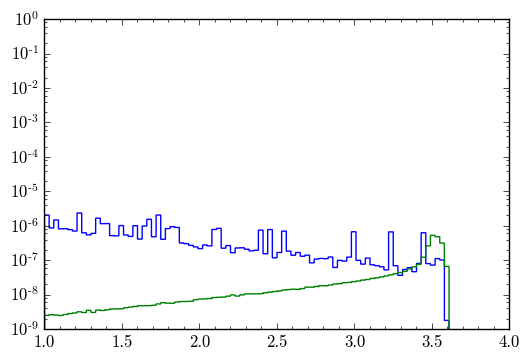

In [69]:
# plt.figure(figsize=(6.8*2,4.8))
# plt.subplot(1,2,1)
# plt.hist(BothPreds[BothY==0],histtype='step',bins=100,normed='True')#,weights=BothWeights[BothY==0]/100)
# plt.hist(BothPreds[BothY==1],histtype='step',bins=100,normed='True')#,weights=BothWeights[BothY==1]/100)
# plt.yscale('log')
# # plt.ylim(1e-9,1)

# plt.subplot(1,2,2)
plt.hist(-np.log10(np.log(2-BackgroundCombinedPreds)),histtype='step',bins=100,range=(1,4),weights=ZJet_weighted['weight']/100)
plt.hist(-np.log10(np.log(2-GluinoCombinedPreds)),histtype='step',bins=100,range=(1,4),weights=Gluinos_1stGen['weight']/100)
plt.yscale('log')
plt.ylim(1e-9,1)
plt.minorticks_on()
plt.show()

In [70]:
# x = np.linspace(.7,3,100)
# xt = []
# y = []
# for xi in x:
#     xt.append(2 - np.exp(10**(-xi)))
#     y.append( ZJet_weighted[BackgroundCombinedPreds>xt[-1]]['weight'].sum()*1000)
# #         Gluinos_1stGen[(GluinoCombinedPreds > xi)]['weight'].sum()*1000-gluinoxs_Weak)
# minval2 = np.argmin(abs(np.array(y)-backgroundxs_Weak))
# plt.plot(x,y)
# # plt.yscale('log')
# plt.hlines(backgroundxs_Weak,0,3)
# plt.minorticks_on()
# # plt.plot(xt,y)
# plt.show()

# print "Threshold combined is", x[minval2], xt[minval2]


In [71]:
# combinedThresh = 2 - np.exp(10**(-3.7))

Background_Combined_XS = ZJet_weighted[BackgroundCombinedPreds> combinedThresh]['weight'].sum()*1000
Signal_Combined_XS = Gluinos_1stGen[GluinoCombinedPreds> combinedThresh]['weight'].sum()*1000

print Signal_Combined_XS, gluinoxs_Weak, gluinoxs_Full, Background_Combined_XS

print combinedThresh, Background_Combined_XS / backgroundxs_Weak

0.175068397322 0.155562980196 0.176049497442 0.041271096596
0.999635127375 0.905398854041


In [72]:
backgroundxs_Full=ZJet_weighted[Full_Weighted_predictions>FullThreshold_New]['weight'].sum()*1000
print backgroundxs_Full, Background_Combined_XS

0.045614121764 0.041271096596


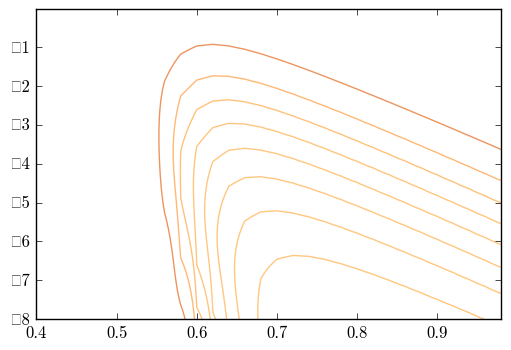

In [73]:
xx, yy = np.meshgrid(np.arange(.4,1, 0.02),
                         np.arange(-8, 0,.02))

cm = plt.cm.RdBu
Z = CombinedModel.predict(scaler2.transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, cmap="copper",levels=2-np.exp(10**(-1*np.linspace(0,4,10))) )
# plt.scatter(Combined0[:,0],Combined0[:,1])
# plt.xlim(-1.5,2.5)
# plt.ylim(-1,2)
plt.show()

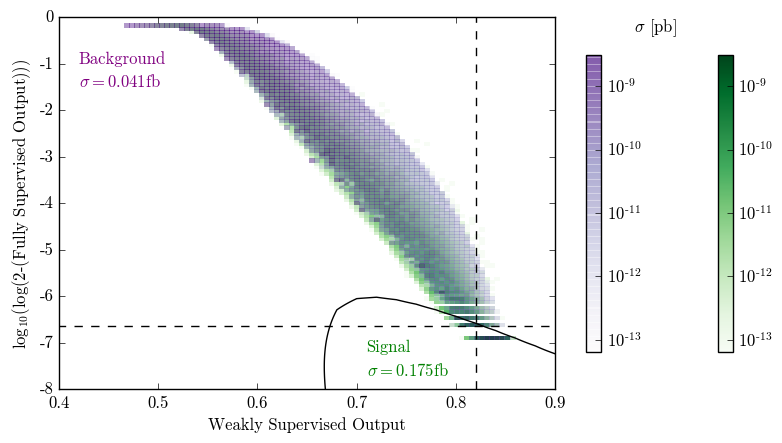

In [77]:
BothX_un = scaler2.inverse_transform(BothX)

hBack,xBack,yBack = np.histogram2d(scaler2.inverse_transform(BackgroundCombinedX)[:,0].flatten(),
                                   scaler2.inverse_transform(BackgroundCombinedX)[:,1].flatten(),
                                   bins=[np.linspace(.4,.9,100),np.linspace(-7,0,100)],
                                   weights=ZJet_weighted['weight']/100**2
                                  )

hSig,xSig,ySig = np.histogram2d(scaler2.inverse_transform(GluinoCombinedX)[:,0].flatten(),
                                scaler2.inverse_transform(GluinoCombinedX)[:,1].flatten(),
                                bins=[np.linspace(.4,.9,100),np.linspace(-7,0,100)],
                                weights=Gluinos_1stGen['weight']/100**2
                                )
hBack=hBack.T
hSig = hSig.T

fig = plt.figure(figsize=(10,4.8))
ax = fig.add_subplot(111)

c1 =ax.pcolor(xSig, ySig, hSig,cmap='Greens',norm=colors.LogNorm(vmin= hSig[hSig>0].min(),
                                                                 vmax= hSig.max()),alpha=1)
c2 =ax.pcolor(xBack, yBack, hBack,cmap='Purples',norm=colors.LogNorm(vmin= hSig[hSig>0].min(),
                                                                     vmax= hSig.max()),alpha=0.4)


cbar1=fig.colorbar(c1,shrink=0.8)
cbar2=fig.colorbar(c2,shrink=0.8)

# plt.contour(xx, yy, Z, cmap="copper",levels=2-np.exp(10**(-1*np.linspace(0,4,10))) )
plt.contour(xx, yy, Z, levels=[combinedThresh], cmap="Greys_r")

plt.vlines(WeakThreshold_New,-8,1,linestyles='--')
plt.hlines(np.log10(np.log(2-FullThreshold_New)),-1.5,2.5,linestyles='--')
plt.text(.98,.0,r'$\sigma$ [pb]',va='top')
plt.ylim(-8,0)
plt.yticks(range(-8,1),range(-8,1))
plt.xlim(.4,.9)
# plt.yscale('log')
plt.xlabel('Weakly Supervised Output')
plt.ylabel(r'log$_{10}$(log(2-(Fully Supervised Output)))')
plt.text(.42,-1,'Background',color='purple',ha='left',fontsize=12)
plt.text(.71,-7.2,'Signal',color='green',ha='left',fontsize=12)

plt.text(.42,-1.5,r'$\sigma=$'+'{0:.3f}fb'.format(Background_Combined_XS),color='purple',ha='left',fontsize=12)
plt.text(.71,-7.7,r'$\sigma=$'+'{0:.3f}fb'.format(Signal_Combined_XS),color='green',ha='left',fontsize=12)
# plt.hlines(np.log(2-ThreshFullB01),0,.6,linestyle='--',color='black')
# plt.vlines(ThreshWeakB01,1e-6,1,linestyle='--',color='black')

plt.savefig('/Users/bryan/Desktop/BothOutputs.pdf',bbox_inches='tight')
plt.show()

In [63]:
CombinedModel= Sequential()
CombinedModel.add(Dense(30, 
                        kernel_initializer="normal",
                        activation="sigmoid", 
                        input_dim=2,
#                         kernel_regularizer=regularizers.l2(0.000001), 
                       )
                 )
CombinedModel.add(Dense(1, activation="sigmoid", kernel_initializer="normal"))
CombinedModel.compile(loss='binary_crossentropy',optimizer=Adam(lr=.0001))

CombinedModel.fit(BothX, 
                  BothY,
                  sample_weight = BothWeights_train,
                  epochs=10,
                  verbose=1,
                  validation_split = 0.1,
#                   batch_size=1214001/100
                 )

Train on 1214001 samples, validate on 134890 samples
Epoch 1/10
1214001/1214001 [==============================] - 107s - loss: 0.0239 - val_loss: 0.0038
Epoch 2/10
1214001/1214001 [==============================] - 104s - loss: 0.0016 - val_loss: 0.0031
Epoch 3/10
1214001/1214001 [==============================] - 111s - loss: 0.0015 - val_loss: 0.0030
Epoch 4/10
1214001/1214001 [==============================] - 116s - loss: 0.0015 - val_loss: 0.0028
Epoch 5/10
1214001/1214001 [==============================] - 112s - loss: 0.0015 - val_loss: 0.0029
Epoch 6/10
1214001/1214001 [==============================] - 112s - loss: 0.0015 - val_loss: 0.0029
Epoch 7/10
1214001/1214001 [==============================] - 114s - loss: 0.0015 - val_loss: 0.0028
Epoch 8/10
1214001/1214001 [==============================] - 117s - loss: 0.0015 - val_loss: 0.0027
Epoch 9/10
1214001/1214001 [==============================] - 114s - loss: 0.0015 - val_loss: 0.0028
Epoch 10/10
1214001/1214001 [=========